# Model Training

In [62]:
# load data
import pandas as pd
import tensorflow as tf
from tensorflow.data import Dataset
from DGMM_utils import getslabels, get_fp

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
tf.random.set_seed(358)

batch_size = 16
train_size = 800000
test_size = 80000
pad_to_len = 80

def get_ds_smi(train_data, test_data):
    inp_train = getslabels(train_data['smiles'].values)
    inp_fp = get_fp(train_data['smiles'])
    train_ds = Dataset.from_tensor_slices((inp_train, inp_fp))
    train_ds = train_ds.batch(batch_size)
    inp_test = getslabels(test_data['smiles'].values)
    test_fp = get_fp(test_data['smiles'])
    test_ds = Dataset.from_tensor_slices((inp_test, test_fp))
    test_ds = test_ds.batch(batch_size)
    print(f'load train set: {len(train_data)} mols, test set {len(test_data)} mols.')
    return train_ds, test_ds

In [22]:
# df = pd.read_hdf('data/zinc_train_ext.h5')
df = pd.read_hdf('data/zinc_train.h5')

train_df = df[df['split']=='train']
test_df = df[df['split']=='test']
train_df = train_df[train_df['smiles'].str.len()<80]
test_df = test_df[test_df['smiles'].str.len()<80]

if len(train_df) > train_size:
    train_df = train_df.sample(n=train_size)
if len(test_df) > test_size:
    test_df = test_df.sample(n=test_size)
train_ds, test_ds = get_ds_smi(train_df, test_df)

load train set: 150274 mols, test set 37556 mols.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from DGMM_utils import VAEsmi

    
class lrScheduler(keras.callbacks.Callback):
    def __init__(self, ep=2, verbose=0):
        super(lrScheduler, self).__init__()
        self.verbose = verbose
        self.ep = ep

    def on_epoch_begin(self, epoch, logs=None):
        lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        ak = float(keras.backend.get_value(self.model.ak))
        if epoch > self.ep:
            lr = lr * tf.math.exp(-0.1)
            if ak > 1e-3:
                ak = 1e-4
            else:
                self.model.ak = ak + 1e-4
            self.model.ak = ak
            self.model.optimizer.learning_rate.assign(lr)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.learning_rate)
        logs['ak'] = keras.backend.get_value(self.model.ak)

checkpoint = keras.callbacks.ModelCheckpoint('test/DGMM_smi.keras', monitor='loss', verbose=1, save_best_only=True)
callbacks=[keras.callbacks.TerminateOnNaN(), lrScheduler(), checkpoint]
model1 = VAEsmi(pad_to_len, ak=1e-4, lr=1e-3)
model1.compile()

In [64]:
his = model1.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=callbacks)

Epoch 1/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - acc: 0.5595 - fp_loss: 0.3734 - kl_loss: 130.0024 - loss: 1.3903 - total_loss: 1.7767
Epoch 1: loss improved from inf to 1.20325, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1361s 143ms/step - acc: 0.5595 - fp_loss: 0.3734 - kl_loss: 130.0053 - loss: 1.3903 - total_loss: 1.7767 - val_acc: 0.6687 - val_fp_loss: 0.2888 - val_loss: 77.8071 - lr: 0.0010 - ak: 1.0000e-04
Epoch 2/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - acc: 0.6982 - fp_loss: 0.2805 - kl_loss: 219.4046 - loss: 0.8712 - total_loss: 1.4331
Epoch 2: loss improved from 1.20325 to 0.81468, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1335s 142ms/step - acc: 0.6982 - fp_loss: 0.2805 - kl_loss: 219.4055 - loss: 0.8712 - total_loss: 1.4331 - val_acc: 0.7278 - val_fp_loss: 0.2744 - val_loss: 64.1510 - lr: 0.0010 - ak: 1.0000e-04
Epoch 3/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - acc: 0.7603 - fp_loss: 0.2516 - kl_los

Epoch 17/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - acc: 0.9328 - fp_loss: 0.1465 - kl_loss: 270.0297 - loss: 0.1871 - total_loss: 0.6335
Epoch 17: loss improved from 0.19527 to 0.18540, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1345s 143ms/step - acc: 0.9328 - fp_loss: 0.1465 - kl_loss: 270.0297 - loss: 0.1871 - total_loss: 0.6335 - val_acc: 0.9265 - val_fp_loss: 0.1471 - val_loss: 16.8417 - lr: 2.4660e-04 - ak: 1.0000e-04
Epoch 18/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - acc: 0.9361 - fp_loss: 0.1443 - kl_loss: 270.6146 - loss: 0.1776 - total_loss: 0.6175
Epoch 18: loss improved from 0.18540 to 0.17639, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1297s 138ms/step - acc: 0.9361 - fp_loss: 0.1443 - kl_loss: 270.6146 - loss: 0.1776 - total_loss: 0.6175 - val_acc: 0.9300 - val_fp_loss: 0.1452 - val_loss: 16.1053 - lr: 2.2313e-04 - ak: 1.0000e-04
Epoch 19/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - acc: 0.9390 - fp_loss

Epoch 33/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - acc: 0.9593 - fp_loss: 0.1306 - kl_loss: 275.0506 - loss: 0.1131 - total_loss: 0.4706
Epoch 33: loss improved from 0.11440 to 0.11249, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1248s 133ms/step - acc: 0.9593 - fp_loss: 0.1306 - kl_loss: 275.0507 - loss: 0.1131 - total_loss: 0.4706 - val_acc: 0.9472 - val_fp_loss: 0.1327 - val_loss: 12.8857 - lr: 4.9787e-05 - ak: 1.0000e-04
Epoch 34/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - acc: 0.9600 - fp_loss: 0.1302 - kl_loss: 275.3676 - loss: 0.1113 - total_loss: 0.4646
Epoch 34: loss improved from 0.11249 to 0.11078, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1254s 134ms/step - acc: 0.9600 - fp_loss: 0.1302 - kl_loss: 275.3676 - loss: 0.1113 - total_loss: 0.4646 - val_acc: 0.9476 - val_fp_loss: 0.1322 - val_loss: 12.8671 - lr: 4.5049e-05 - ak: 1.0000e-04
Epoch 35/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - acc: 0.9605 - fp_loss

Epoch 49/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - acc: 0.9644 - fp_loss: 0.1273 - kl_loss: 277.3077 - loss: 0.0994 - total_loss: 0.4011
Epoch 49: loss improved from 0.09938 to 0.09900, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1224s 130ms/step - acc: 0.9644 - fp_loss: 0.1273 - kl_loss: 277.3077 - loss: 0.0994 - total_loss: 0.4011 - val_acc: 0.9508 - val_fp_loss: 0.1298 - val_loss: 12.3513 - lr: 1.0052e-05 - ak: 1.0000e-04
Epoch 50/50
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - acc: 0.9645 - fp_loss: 0.1272 - kl_loss: 277.2655 - loss: 0.0991 - total_loss: 0.3981
Epoch 50: loss improved from 0.09900 to 0.09871, saving model to test/DGMM_smi.keras
9393/9393 ━━━━━━━━━━━━━━━━━━━━ 1241s 132ms/step - acc: 0.9645 - fp_loss: 0.1272 - kl_loss: 277.2655 - loss: 0.0991 - total_loss: 0.3981 - val_acc: 0.9510 - val_fp_loss: 0.1297 - val_loss: 12.3444 - lr: 9.0953e-06 - ak: 1.0000e-04


In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Visualizes the training history from a Keras model.fit() call.
    
    Parameters:
    history: History object returned by model.fit()
    """
    
    # 获取history中的所有metric名称
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    
    # 创建子图，每个metric一个
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, 5*n_metrics))
    
    # 如果只有一个metric，确保axes是可迭代的
    if n_metrics == 1:
        axes = [axes]
    
    # 遍历每个metric
    for i, metric in enumerate(metrics):
        # 获取训练和验证数据
        train_values = history.history[metric]
        val_metric = f'val_{metric}'
        val_values = history.history.get(val_metric)
        
        # 创建epoch范围
        epochs = range(1, len(train_values) + 1)
        
        # 绘制训练数据
        axes[i].plot(epochs, train_values, 'b-', label=f'Training {metric}')
        
        # 如果有验证数据，也绘制
        if val_values:
            axes[i].plot(epochs, val_values, 'r-', label=f'Validation {metric}')
        
        # 设置标题和标签
        axes[i].set_title(f'Training and Validation {metric.capitalize()}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)
    
    # 调整布局防止重叠
    plt.tight_layout()
    plt.show()

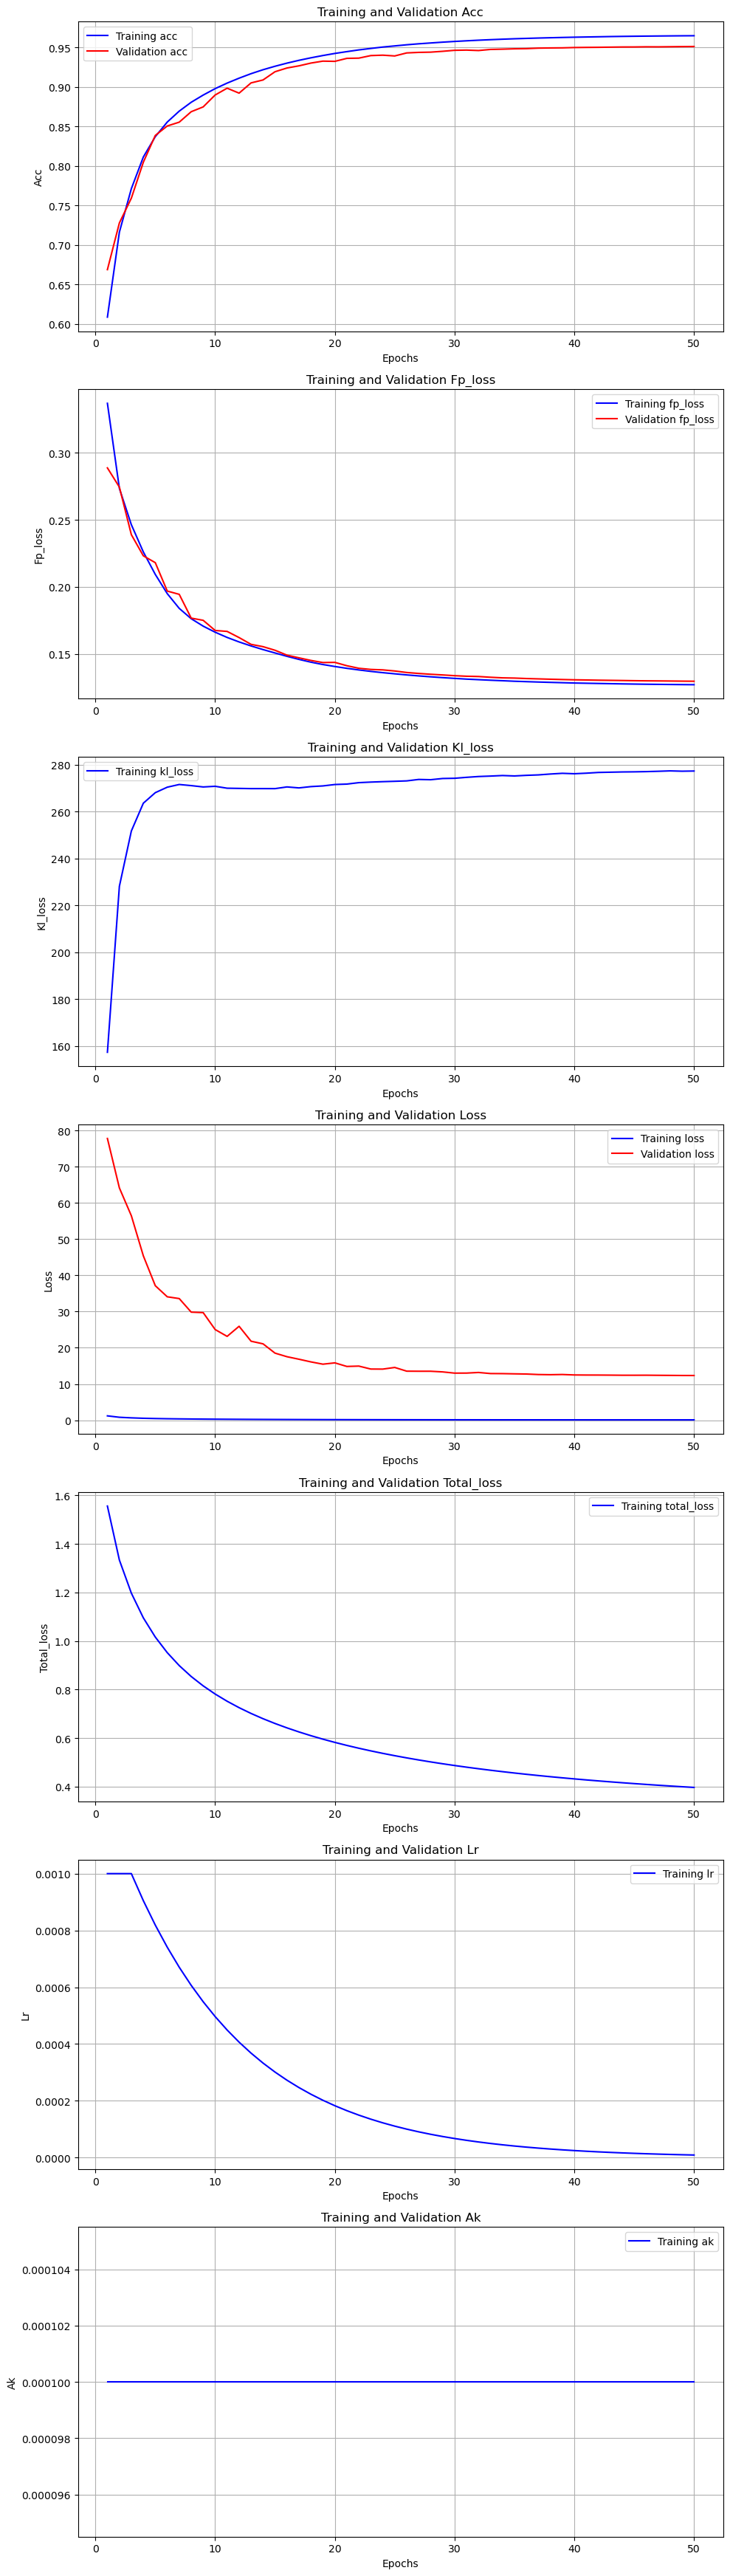

In [79]:
plot_training_history(his)

# SMILES test

In [27]:
from tensorflow.keras.models import load_model
from DGMM_utils import Sampling
encoder = load_model(f'model/DGMM_smi_encoder.keras', custom_objects={'Sampling':Sampling})
decoder = load_model(f'model/DGMM_smi_decoder.keras')

In [28]:
import numpy as np
from DGMM_utils import alphabet, chars

def pro2smi(data, attempts=1000):
    res = []
    for y_pred in data:
        atmp = attempts
        while atmp > 0:
            atmp -= 1
            smiles = ''
            for p in y_pred:
                idx = np.random.choice(np.arange(len(chars)+2), p=p)
                if idx == 0 or idx == len(chars)+1:
                    break
                token = chars[idx-1]
                smiles+=token
            try:
                mol = Chem.MolFromSmiles(smiles)
                smiles = Chem.MolToSmiles(mol, canonical=True)
                assert len(smiles) > 1
                res.append(smiles)
                atmp = -1
            except:
                pass
        if atmp != -1:
            res.append('')
    return res

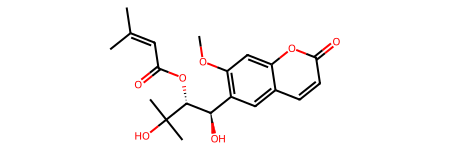

In [58]:
from rdkit import Chem
import pandas as pd
df = pd.read_hdf('data/zinc_train.h5')

smi = df.sample(n=10)['smiles'].values
Chem.MolFromSmiles(smi[0])

In [39]:
from DGMM_utils import getslabels
label = getslabels(smi)
latent = encoder.predict(label, verbose=1)
pred = decoder.predict(latent[2], verbose=1)
res = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [40]:
pro2smi(res)

['', '', '', '', 'CCCCCCNCCN1C=CC=C(CF)C=C1', '', '', '', '', '']

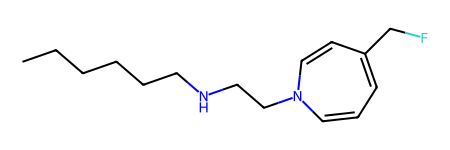

In [41]:
Chem.MolFromSmiles('CCCCCCNCCN1C=CC=C(CF)C=C1')